## Notebooks to make the queries to the api of the models to get the response

In [1]:
import pandas as pd
import requests
from typing import Dict
import time
import os
import json
import re
import seaborn as sns
from matplotlib import pyplot as plt

### Reading the data

In [2]:
data = pd.read_csv("../02-dataset/data/cleaned/all_questions_df_english.csv")
data

,Unnamed: 0,description,alternatives,year,subject,ground_truth,index_question,text_concat_english,text_concat_portuguese
0,0,Questão 4) A Minor Bird I have wished a bird w...,"['A) culpa por não poder cuidar do pássaro.', ...",2020,"Linguagens, códigos e suas tecnologias",D,4,Question 4) Minor Bird I Have Wished a Bird Wo...,Questão 4) A Minor Bird I have wished a bird w...
1,1,"Questão 5) Finally, Aisha finished with her cu...","['A) reforçam um padrão de beleza.', 'B) retra...",2020,"Linguagens, códigos e suas tecnologias",C,5,"Question 5) Finally, Aisha Finished with Her C...","Questão 5) Finally, Aisha finished with her cu..."
2,2,Questão 01) Pablo Pueblo Regresa un hombre en ...,['A) contrapor a individualidade de um sujeito...,2020,"Linguagens, códigos e suas tecnologias",A,6,Question 01) Pablo Pueblo returns a Hombre en ...,Questão 01) Pablo Pueblo Regresa un hombre en ...
3,3,"Questão 4) Oye, Pito, ésta es: la vida bruta d...",['A) rejeição da língua utilizada por seus ant...,2020,"Linguagens, códigos e suas tecnologias",E,9,"Question 4) Oye, Pito, Estas Es: La Life of Un...","Questão 4) Oye, Pito, ésta es: la vida bruta d..."
4,4,Questão 5) Poco después apareció en casa de El...,['A) determinação para conduzir discussões pes...,2020,"Linguagens, códigos e suas tecnologias",E,10,Question 5) Poco Después Apareció en House of ...,Questão 5) Poco después apareció en casa de El...
...,...,...,...,...,...,...,...,...,...
1001,1001,QuESTÃO 167) Em um jogo disputado em uma mesa ...,"['A) Arthur, pois a soma que escolheu é a meno...",2011,Matemática e suas tecnologias,C,172,Question 167) In a game played at a pool table...,QuESTÃO 167) Em um jogo disputado em uma mesa ...
1002,1002,QuESTÃO 168) É possível usar água ou comida pa...,"['A) 20 mL.', 'B) 24 mL.', 'C) 100 mL.', 'D) 1...",2011,Matemática e suas tecnologias,C,173,Question 168) It is possible to use water or f...,QuESTÃO 168) É possível usar água ou comida pa...
1003,1003,"QuESTÃO 171) Nos últimos cinco anos, 32 mil mu...","['A) 4 mil.', 'B) 9 mil.', 'C) 21 mil.', 'D) 3...",2011,Matemática e suas tecnologias,D,176,"Question 171) In the last five years, 32,000 w...","QuESTÃO 171) Nos últimos cinco anos, 32 mil mu..."
1004,1004,QuESTÃO 174) O setor de recursos humanos de um...,"['A) 24.', 'B) 31.', 'C) 32.', 'D) 88.', 'E) 8...",2011,Matemática e suas tecnologias,E,179,Question 174) The human resources sector of a ...,QuESTÃO 174) O setor de recursos humanos de um...


## Making the requests

In [3]:
def get_text(line : pd.Series, lang: str, verbose = False):
    """
    """
    if lang == 'pt':
        prompt = \
        f"""Qual é a alternativa correta para a questão que está entre <>? responda só com a letra que representa a alternativa:\n\n<{line['text_concat_portuguese']}>"""
    else:
        prompt = \
        f"""What is the correct alternative to the question between <>? Answer only with the letter that represents the alternative:\n\n<{line['text_concat_english']}>"""

    if verbose:
        print(prompt)
    return prompt

def make_querie(url : str, text : str, temperature: float = None, stop_tokens: str = None):
    """
    """
    params = {}
    params['query'] = text
    if not(temperature is None):
        params['temperature'] = temperature
    if not(stop_tokens is None):
        params['stop_tokens'] = stop_tokens
    start_time = time.time()
    request = requests.get(url, params = params)

    return_infos = {
        'time_to_run': time.time() - start_time,
        'result': eval(request.text)['result']
    }
    
    return return_infos

def make_all_requests(
        df: pd.DataFrame, 
        models: Dict, 
        temperature: float,
        stop_tokens: str,
        path_to_save: str,
        lang: str,
        base_path: str = "http://localhost:8000",
        verbose: bool = True
    ):
    """
    """
    
    try:
        os.mkdir(path_to_save)
    except:
        pass

    for model,url in models.items():
        
        for index,line in df.iterrows():
            name_arq = f"{line['year']}-{line['index_question']}-{model}.json"
            full_path_arq = f"{path_to_save}/{name_arq}"
            
            # if alredy process, not process
            if os.path.exists(full_path_arq):
                continue
            
            # otherwise compute
            url_req = base_path + url
            
            result = make_querie(
                url = url_req,
                text = get_text(line, lang),
                temperature = temperature,
                stop_tokens = stop_tokens
            )
            
            with open(full_path_arq, 'w') as file:
                file.write(json.dumps(result,indent=2,ensure_ascii=False))
            
            if verbose:
                print(f"--> {model} || {index} || {result}")

        print(f"Run the model {model}")
    

In [4]:
models = {
    "llama_7b":"/models/llama/7b",
    "llama_13b":"/models/llama/13b",
    "alpaca_7b": "/models/alpaca/7b",
    "alpaca_13b": "/models/alpaca/13b",
    "koala_7b": "/models/koala/7b",
    "koala_13b": "/models/koala/13b",
    "vicuna_7b": "/models/vicuna/7b",
    "vicuna_13b": "/models/vicuna/13b",
    "llama_2_7b": "/models/llama2/7b/",
    "llama_2_13b": "/models/llama2/13b/",
#     "vicuna1.5_7b": "/models/vicuna1.5/7b/",
#     "vicuna1.5_13b": "/models/vicuna1.5/13b/",
}

### First experiment. Only concatenating the text and seding to the model and collecting the response
- PT BR

In [6]:
PATH_SAVE_DATA = "data/04-prompt-ask"
LANG = 'en'
BASE_PATH = "http://localhost:8000"

make_all_requests(
    df = data,
    models = models,
    temperature = 0.1,
    stop_tokens = "pergunta:,</s>,\n",
    path_to_save = PATH_SAVE_DATA,
    lang = LANG,
    base_path = BASE_PATH
)

Run the model llama_7b
Run the model llama_13b
Run the model alpaca_7b
Run the model alpaca_13b
Run the model koala_7b
Run the model koala_13b
Run the model vicuna_7b
Run the model vicuna_13b
--> llama_2_7b || 0 || {'time_to_run': 13.932859182357788, 'result': ' A'}
--> llama_2_7b || 1 || {'time_to_run': 28.106574535369873, 'result': ' C) reveal an attitude of resistance.'}
--> llama_2_7b || 2 || {'time_to_run': 13.620575904846191, 'result': ' A'}
--> llama_2_7b || 3 || {'time_to_run': 15.242230892181396, 'result': ' D) claim of a unified world.'}
--> llama_2_7b || 4 || {'time_to_run': 19.525415182113647, 'result': ' E'}
--> llama_2_7b || 5 || {'time_to_run': 4.924067497253418, 'result': ' A'}
--> llama_2_7b || 6 || {'time_to_run': 18.139107704162598, 'result': ' D) Explorations of speaking of a specific social group.'}
--> llama_2_7b || 7 || {'time_to_run': 17.770435094833374, 'result': ' A'}
--> llama_2_7b || 8 || {'time_to_run': 14.283667087554932, 'result': ' A'}
--> llama_2_7b || 

--> llama_2_7b || 77 || {'time_to_run': 9.209275484085083, 'result': ' D) 36%'}
--> llama_2_7b || 78 || {'time_to_run': 7.489330291748047, 'result': ' A'}
--> llama_2_7b || 79 || {'time_to_run': 11.520067691802979, 'result': ' C) Construction of ecological corridors.'}
--> llama_2_7b || 80 || {'time_to_run': 17.069348573684692, 'result': ' B) 6.25 × 10−2 mol l - 1'}
--> llama_2_7b || 81 || {'time_to_run': 9.112014293670654, 'result': ' D'}
--> llama_2_7b || 82 || {'time_to_run': 13.347126722335815, 'result': ' A'}
--> llama_2_7b || 83 || {'time_to_run': 9.3644540309906, 'result': ' D'}
--> llama_2_7b || 84 || {'time_to_run': 13.776864528656006, 'result': ' D) 40'}
--> llama_2_7b || 85 || {'time_to_run': 12.70999026298523, 'result': ' D) 104'}
--> llama_2_7b || 86 || {'time_to_run': 14.255646228790283, 'result': ' D) 31.5 ≤ b ≤ 33'}
--> llama_2_7b || 87 || {'time_to_run': 11.02821660041809, 'result': ' B) x 100'}
--> llama_2_7b || 88 || {'time_to_run': 9.359433650970459, 'result': ' D) 

--> llama_2_7b || 160 || {'time_to_run': 11.462974309921265, 'result': ' D'}
--> llama_2_7b || 161 || {'time_to_run': 19.931196451187134, 'result': ' A'}
--> llama_2_7b || 162 || {'time_to_run': 11.322760105133057, 'result': ' B'}
--> llama_2_7b || 163 || {'time_to_run': 10.55344533920288, 'result': ' D'}
--> llama_2_7b || 164 || {'time_to_run': 9.837083339691162, 'result': ' E'}
--> llama_2_7b || 165 || {'time_to_run': 10.18684434890747, 'result': ' B'}
--> llama_2_7b || 166 || {'time_to_run': 9.151178121566772, 'result': ' D) recognition of a legal authority.'}
--> llama_2_7b || 167 || {'time_to_run': 14.48291563987732, 'result': ' D) establishment of limits to public actors and government institutions.'}
--> llama_2_7b || 168 || {'time_to_run': 11.124543905258179, 'result': ' A'}
--> llama_2_7b || 169 || {'time_to_run': 16.16692876815796, 'result': ' D'}
--> llama_2_7b || 170 || {'time_to_run': 11.289687633514404, 'result': ' D) Implementation of social rights.'}
--> llama_2_7b || 1

--> llama_2_7b || 253 || {'time_to_run': 18.180313110351562, 'result': ' B'}
--> llama_2_7b || 254 || {'time_to_run': 23.236513137817383, 'result': ' E'}
--> llama_2_7b || 255 || {'time_to_run': 15.417630910873413, 'result': ' B'}
--> llama_2_7b || 256 || {'time_to_run': 20.87392258644104, 'result': ' D) Introduce the recipient of the letter, characterizing his personality.'}
--> llama_2_7b || 257 || {'time_to_run': 13.830981254577637, 'result': ' B) Overlapping of traditional elements on modern.'}
--> llama_2_7b || 258 || {'time_to_run': 17.454023599624634, 'result': ' D) nationalist, when denying foreign models.'}
--> llama_2_7b || 259 || {'time_to_run': 21.1495463848114, 'result': ' D) narrative sequencement in which absurd events are articulated.'}
--> llama_2_7b || 260 || {'time_to_run': 19.368136644363403, 'result': ' A) Democratizes access to products built collectively.'}
--> llama_2_7b || 261 || {'time_to_run': 13.226894617080688, 'result': ' C'}
--> llama_2_7b || 262 || {'tim

--> llama_2_7b || 338 || {'time_to_run': 13.308040142059326, 'result': ' D'}
--> llama_2_7b || 339 || {'time_to_run': 12.783207654953003, 'result': ' B) 25%'}
--> llama_2_7b || 340 || {'time_to_run': 10.348040103912354, 'result': ' D) 1.1 × 10-4'}
--> llama_2_7b || 341 || {'time_to_run': 17.399892568588257, 'result': ' D) 28.'}
--> llama_2_7b || 342 || {'time_to_run': 20.380842685699463, 'result': ' D) It will not be sufficient, as the area of \u200b\u200bthe new region to be paved measures 108 m2.'}
--> llama_2_7b || 343 || {'time_to_run': 8.312095642089844, 'result': ' D) Thursday'}
--> llama_2_7b || 344 || {'time_to_run': 9.149065494537354, 'result': ' D) 112'}
--> llama_2_7b || 345 || {'time_to_run': 12.745144128799438, 'result': ' D) 404.00'}
--> llama_2_7b || 346 || {'time_to_run': 11.771504402160645, 'result': ' B'}
--> llama_2_7b || 347 || {'time_to_run': 12.04102635383606, 'result': ' B'}
--> llama_2_7b || 348 || {'time_to_run': 14.630232334136963, 'result': ' B) catalyst.'}
-

--> llama_2_7b || 426 || {'time_to_run': 7.196819067001343, 'result': ' D) seasonal displacement'}
--> llama_2_7b || 427 || {'time_to_run': 11.024237871170044, 'result': ' D) conurbation area'}
--> llama_2_7b || 428 || {'time_to_run': 20.67846417427063, 'result': ' D) direct transposition of the categories originated in the medieval imagination.'}
--> llama_2_7b || 429 || {'time_to_run': 10.385076761245728, 'result': ' A'}
--> llama_2_7b || 430 || {'time_to_run': 17.293619871139526, 'result': ' B'}
--> llama_2_7b || 431 || {'time_to_run': 11.787597894668579, 'result': ' C'}
--> llama_2_7b || 432 || {'time_to_run': 12.765140056610107, 'result': ' D) jurisdiction of territorial sovereignty'}
--> llama_2_7b || 433 || {'time_to_run': 15.686041831970215, 'result': ' D) Repression of opposition activists.'}
--> llama_2_7b || 434 || {'time_to_run': 11.926778793334961, 'result': ' C'}
--> llama_2_7b || 435 || {'time_to_run': 11.382415533065796, 'result': ' E'}
--> llama_2_7b || 436 || {'time_t

--> llama_2_7b || 511 || {'time_to_run': 9.275166749954224, 'result': ' B) implicit information'}
--> llama_2_7b || 512 || {'time_to_run': 14.38268494606018, 'result': ' D) Scientific denomination based on Greek terms.'}
--> llama_2_7b || 513 || {'time_to_run': 25.75490641593933, 'result': ' D) enumeration of different lyrical manifestations produces an effect of impersonality.'}
--> llama_2_7b || 514 || {'time_to_run': 24.785205841064453, 'result': ' B'}
--> llama_2_7b || 515 || {'time_to_run': 14.438971519470215, 'result': ' D) increase in 4 units.'}
--> llama_2_7b || 516 || {'time_to_run': 14.990188598632812, 'result': ' B'}
--> llama_2_7b || 517 || {'time_to_run': 11.095320224761963, 'result': ' B) 1 250'}
--> llama_2_7b || 518 || {'time_to_run': 11.108421802520752, 'result': ' B'}
--> llama_2_7b || 519 || {'time_to_run': 12.220275640487671, 'result': ' B'}
--> llama_2_7b || 520 || {'time_to_run': 7.301984548568726, 'result': ' D'}
--> llama_2_7b || 521 || {'time_to_run': 17.401980

--> llama_2_7b || 599 || {'time_to_run': 10.14176082611084, 'result': ' C'}
--> llama_2_7b || 600 || {'time_to_run': 11.627270460128784, 'result': ' A) Development of autonomous thinking.'}
--> llama_2_7b || 601 || {'time_to_run': 14.881770133972168, 'result': ' D) Distribution of indigenous sociocultural values \u200b\u200bby the Portuguese.'}
--> llama_2_7b || 602 || {'time_to_run': 13.108731985092163, 'result': ' A) privatization of the economy'}
--> llama_2_7b || 603 || {'time_to_run': 13.542320251464844, 'result': ' D'}
--> llama_2_7b || 604 || {'time_to_run': 6.876208066940308, 'result': ' D) centralization of political power.'}
--> llama_2_7b || 605 || {'time_to_run': 12.589838743209839, 'result': ' D) social conventions resulting from contingent human interests.'}
--> llama_2_7b || 606 || {'time_to_run': 14.575826406478882, 'result': ' B'}
--> llama_2_7b || 607 || {'time_to_run': 13.103657960891724, 'result': ' C'}
--> llama_2_7b || 608 || {'time_to_run': 11.838602066040039, 'r

--> llama_2_7b || 683 || {'time_to_run': 15.513702869415283, 'result': ' D'}
--> llama_2_7b || 684 || {'time_to_run': 11.379045963287354, 'result': ' D) 35'}
--> llama_2_7b || 685 || {'time_to_run': 9.004139184951782, 'result': ' D) 65.7%'}
--> llama_2_7b || 686 || {'time_to_run': 13.254077672958374, 'result': ' B) 2 093.00'}
--> llama_2_7b || 687 || {'time_to_run': 9.886739730834961, 'result': ' B) 4.129 × 106'}
--> llama_2_7b || 688 || {'time_to_run': 13.685001134872437, 'result': ' B) 548.11'}
--> llama_2_7b || 689 || {'time_to_run': 17.55426001548767, 'result': ''}
--> llama_2_7b || 690 || {'time_to_run': 9.994055986404419, 'result': ' B) 1.0'}
--> llama_2_7b || 691 || {'time_to_run': 9.836232662200928, 'result': ''}
--> llama_2_7b || 692 || {'time_to_run': 12.790175437927246, 'result': ' D) 108.0'}
--> llama_2_7b || 693 || {'time_to_run': 7.867053031921387, 'result': ''}
--> llama_2_7b || 694 || {'time_to_run': 11.285512924194336, 'result': ' B) II'}
--> llama_2_7b || 695 || {'tim

--> llama_2_7b || 770 || {'time_to_run': 10.791868448257446, 'result': ' A'}
--> llama_2_7b || 771 || {'time_to_run': 26.563235998153687, 'result': ' E'}
--> llama_2_7b || 772 || {'time_to_run': 24.68594193458557, 'result': ' B'}
--> llama_2_7b || 773 || {'time_to_run': 14.298686981201172, 'result': ' B'}
--> llama_2_7b || 774 || {'time_to_run': 7.189840793609619, 'result': ' C'}
--> llama_2_7b || 775 || {'time_to_run': 16.49038314819336, 'result': ' A'}
--> llama_2_7b || 776 || {'time_to_run': 14.418926000595093, 'result': ' A'}
--> llama_2_7b || 777 || {'time_to_run': 34.95428276062012, 'result': ' D) believes that the genuinely Brazilian language is under construction, which requires it to incorporate into its daily life the normative grammar of European Portuguese.'}
--> llama_2_7b || 778 || {'time_to_run': 24.5538387298584, 'result': ' D'}
--> llama_2_7b || 779 || {'time_to_run': 6.545844078063965, 'result': ' A'}
--> llama_2_7b || 780 || {'time_to_run': 13.967162609100342, 'resul

--> llama_2_7b || 855 || {'time_to_run': 18.896303415298462, 'result': ' C'}
--> llama_2_7b || 856 || {'time_to_run': 9.366437196731567, 'result': ' A'}
--> llama_2_7b || 857 || {'time_to_run': 10.127736568450928, 'result': ' A'}
--> llama_2_7b || 858 || {'time_to_run': 10.951134443283081, 'result': ' D'}
--> llama_2_7b || 859 || {'time_to_run': 15.349465131759644, 'result': ' D) 4'}
--> llama_2_7b || 860 || {'time_to_run': 8.519026041030884, 'result': ' D) Chagas disease.'}
--> llama_2_7b || 861 || {'time_to_run': 6.872302055358887, 'result': ' B'}
--> llama_2_7b || 862 || {'time_to_run': 14.87667989730835, 'result': ' B'}
--> llama_2_7b || 863 || {'time_to_run': 13.151781558990479, 'result': ' D) xenon'}
--> llama_2_7b || 864 || {'time_to_run': 11.749463558197021, 'result': ' D) 90'}
--> llama_2_7b || 865 || {'time_to_run': 10.443770408630371, 'result': ' B) 1 433'}
--> llama_2_7b || 866 || {'time_to_run': 14.466993570327759, 'result': ' A'}
--> llama_2_7b || 867 || {'time_to_run': 1

--> llama_2_7b || 946 || {'time_to_run': 13.994250535964966, 'result': ' D'}
--> llama_2_7b || 947 || {'time_to_run': 15.032891035079956, 'result': ' D) Modification of the environment to select better adapted individuals.'}
--> llama_2_7b || 948 || {'time_to_run': 9.641866207122803, 'result': ' C'}
--> llama_2_7b || 949 || {'time_to_run': 26.72956085205078, 'result': ' D) DNA replication is conservative, that is, the daughters ribbons consist of parental DNA molecules.'}
--> llama_2_7b || 950 || {'time_to_run': 15.674787998199463, 'result': ' D) replacement in the hemoglobin beta gene gene.'}
--> llama_2_7b || 951 || {'time_to_run': 10.549452066421509, 'result': ' D) transformation of thermal energy into kinetics is impossible.'}
--> llama_2_7b || 952 || {'time_to_run': 15.953456401824951, 'result': ' D'}
--> llama_2_7b || 953 || {'time_to_run': 10.81996774673462, 'result': ' A'}
--> llama_2_7b || 954 || {'time_to_run': 21.175087451934814, 'result': ' B'}
--> llama_2_7b || 955 || {'ti

--> llama_2_13b || 18 || {'time_to_run': 35.98184013366699, 'result': ' C) legitimize the right of the child to inheritance.'}
--> llama_2_13b || 19 || {'time_to_run': 22.978864669799805, 'result': ' D) Intentional bodily combat with regulated actions between opponents.'}
--> llama_2_13b || 20 || {'time_to_run': 45.954673051834106, 'result': ' A'}
--> llama_2_13b || 21 || {'time_to_run': 21.073026180267334, 'result': ' C) Values \u200b\u200bits elements.'}
--> llama_2_13b || 22 || {'time_to_run': 33.47077536582947, 'result': ' A) moral subjection amplified by poverty.'}
--> llama_2_13b || 23 || {'time_to_run': 31.291178226470947, 'result': ' A) Social situation of enunciation represented.'}
--> llama_2_13b || 24 || {'time_to_run': 28.260942697525024, 'result': ' A) Physical exercise, promoting health.'}
--> llama_2_13b || 25 || {'time_to_run': 23.77962851524353, 'result': ' D) Prejudice.'}
--> llama_2_13b || 26 || {'time_to_run': 25.35215449333191, 'result': ' C) Diversification of the

--> llama_2_13b || 97 || {'time_to_run': 23.88072180747986, 'result': ' C) 70.'}
--> llama_2_13b || 98 || {'time_to_run': 27.139162302017212, 'result': ' C) 26.'}
--> llama_2_13b || 99 || {'time_to_run': 32.81267166137695, 'result': ' B) Create access to free baths for homeless people.'}
--> llama_2_13b || 100 || {'time_to_run': 32.80244970321655, 'result': ' C) Power on memories and records.'}
--> llama_2_13b || 101 || {'time_to_run': 49.27012252807617, 'result': ' B) Tragic destination of Santiago, which Placida was unable to predict in dreams.'}
--> llama_2_13b || 102 || {'time_to_run': 31.783865928649902, 'result': ' C) allocates part of their taxes to fund social programs.'}
--> llama_2_13b || 103 || {'time_to_run': 45.616008281707764, 'result': ' D) explore the relationships between the languages \u200b\u200bstudied to promote diversity.'}
--> llama_2_13b || 104 || {'time_to_run': 38.064295530319214, 'result': ' C) discussion of this theme since basic education.'}
--> llama_2_13b

--> llama_2_13b || 164 || {'time_to_run': 18.648927927017212, 'result': ' B'}
--> llama_2_13b || 165 || {'time_to_run': 19.279627799987793, 'result': ' B'}
--> llama_2_13b || 166 || {'time_to_run': 17.323752403259277, 'result': ' D) recognition of a legal authority.'}
--> llama_2_13b || 167 || {'time_to_run': 27.40551495552063, 'result': ' D) establishment of limits to public actors and government institutions.'}
--> llama_2_13b || 168 || {'time_to_run': 22.84297013282776, 'result': ' B) Transformation of social representations.'}
--> llama_2_13b || 169 || {'time_to_run': 31.42156147956848, 'result': ' D) subtle'}
--> llama_2_13b || 170 || {'time_to_run': 22.162707090377808, 'result': ' C) Affirmation of democratic institutions.'}
--> llama_2_13b || 171 || {'time_to_run': 23.083337783813477, 'result': ' C) purpose of human actions and conduct.'}
--> llama_2_13b || 172 || {'time_to_run': 21.197232723236084, 'result': ' C) Political accommodation.'}
--> llama_2_13b || 173 || {'time_to_ru

--> llama_2_13b || 234 || {'time_to_run': 20.040400981903076, 'result': ' B) s = k • m 1 3'}
--> llama_2_13b || 235 || {'time_to_run': 18.713016271591187, 'result': ' C) 5.'}
--> llama_2_13b || 236 || {'time_to_run': 17.215590238571167, 'result': ' B'}
--> llama_2_13b || 237 || {'time_to_run': 16.072685718536377, 'result': ' C) 2.33'}
--> llama_2_13b || 238 || {'time_to_run': 20.772034645080566, 'result': ' C) 10.00.'}
--> llama_2_13b || 239 || {'time_to_run': 23.435145378112793, 'result': ' C) 400 bricks'}
--> llama_2_13b || 240 || {'time_to_run': 12.503690242767334, 'result': ' C) 1.4'}
--> llama_2_13b || 241 || {'time_to_run': 24.032981157302856, 'result': ' C) 50'}
--> llama_2_13b || 242 || {'time_to_run': 18.676013231277466, 'result': ' A) 0.83.'}
--> llama_2_13b || 243 || {'time_to_run': 22.18184542655945, 'result': ' D) 3x - 2y + 15 = 0'}
--> llama_2_13b || 244 || {'time_to_run': 17.501572370529175, 'result': ' C) 20.0'}
--> llama_2_13b || 245 || {'time_to_run': 12.0729560852050

--> llama_2_13b || 308 || {'time_to_run': 34.49448347091675, 'result': ' A) Symbolic appeal and interregional migration.'}
--> llama_2_13b || 309 || {'time_to_run': 16.115715265274048, 'result': ' D) economic disparity.'}
--> llama_2_13b || 310 || {'time_to_run': 24.612017393112183, 'result': ' A) overcoming state sovereignty.'}
--> llama_2_13b || 311 || {'time_to_run': 27.762676239013672, 'result': ' B) conquer the riches of American territories.'}
--> llama_2_13b || 312 || {'time_to_run': 23.344815254211426, 'result': ' A) Articulate the public agencies.'}
--> llama_2_13b || 313 || {'time_to_run': 18.37747097015381, 'result': ' D) latitude.'}
--> llama_2_13b || 314 || {'time_to_run': 18.733173370361328, 'result': ' B) Standard of income distribution.'}
--> llama_2_13b || 315 || {'time_to_run': 36.41467022895813, 'result': ' B) block of Krebs cycle reactions, resulting in greater cellular energy expenditure.'}
--> llama_2_13b || 316 || {'time_to_run': 30.37449288368225, 'result': ' C)

--> llama_2_13b || 385 || {'time_to_run': 24.00096035003662, 'result': ' B) Weakened the metropolitan domination pact.'}
--> llama_2_13b || 386 || {'time_to_run': 18.64038109779358, 'result': ' C) Federalist territorial model.'}
--> llama_2_13b || 387 || {'time_to_run': 27.52885866165161, 'result': ' D) amplitude of oscillation is constant at any temperature.'}
--> llama_2_13b || 388 || {'time_to_run': 18.811235427856445, 'result': ' C) Natural amino acids.'}
--> llama_2_13b || 389 || {'time_to_run': 22.214081287384033, 'result': ' D) methane gas'}
--> llama_2_13b || 390 || {'time_to_run': 29.90334963798523, 'result': ' D) pH correction by the addition of sodium carbonate.'}
--> llama_2_13b || 391 || {'time_to_run': 18.98654317855835, 'result': ' B) cannot be separated.'}
--> llama_2_13b || 392 || {'time_to_run': 15.585934400558472, 'result': ' C) complexification of their systems.'}
--> llama_2_13b || 393 || {'time_to_run': 27.957481861114502, 'result': ' C) 97.2%'}
--> llama_2_13b ||

--> llama_2_13b || 462 || {'time_to_run': 17.82261347770691, 'result': ' B'}
--> llama_2_13b || 463 || {'time_to_run': 30.54198455810547, 'result': ' C) Decreased intensity, decreased return time and increased perceived frequency.'}
--> llama_2_13b || 464 || {'time_to_run': 19.997241735458374, 'result': ' C) Hydrogen bonds.'}
--> llama_2_13b || 465 || {'time_to_run': 16.415104150772095, 'result': ' B) Zooplankton.'}
--> llama_2_13b || 466 || {'time_to_run': 34.11681652069092, 'result': ' C) 6'}
--> llama_2_13b || 467 || {'time_to_run': 19.082674980163574, 'result': ' E) Hematophagous mosquitoes.'}
--> llama_2_13b || 468 || {'time_to_run': 39.29356837272644, 'result': ' D) change in the spatial structure formed by the different constituents of the material.'}
--> llama_2_13b || 469 || {'time_to_run': 19.491475343704224, 'result': ' C) 60.'}
--> llama_2_13b || 470 || {'time_to_run': 17.804622888565063, 'result': ' E) proteins.'}
--> llama_2_13b || 471 || {'time_to_run': 15.85638356208801

--> llama_2_13b || 539 || {'time_to_run': 34.99027943611145, 'result': ' C) Compare the expectations of loving partners in different times.'}
--> llama_2_13b || 540 || {'time_to_run': 21.54896569252014, 'result': ' C) Concern with the composition of texts.'}
--> llama_2_13b || 541 || {'time_to_run': 29.624313354492188, 'result': ' C) the role of friendship in different contexts.'}
--> llama_2_13b || 542 || {'time_to_run': 33.22131061553955, 'result': ' A) Disregard in the face of the problem of homeless children.'}
--> llama_2_13b || 543 || {'time_to_run': 32.80342245101929, 'result': ' A'}
--> llama_2_13b || 544 || {'time_to_run': 39.85990643501282, 'result': ' D) Emphasis on the use of hyperbole, as in: "A meal that can last a life."'}
--> llama_2_13b || 545 || {'time_to_run': 42.55489659309387, 'result': ' A'}
--> llama_2_13b || 546 || {'time_to_run': 31.55846333503723, 'result': ' A) Difficulty in appropriation of the new language.'}
--> llama_2_13b || 547 || {'time_to_run': 37.396

--> llama_2_13b || 610 || {'time_to_run': 13.57649040222168, 'result': ' C) Protectionism of markets.'}
--> llama_2_13b || 611 || {'time_to_run': 36.210176944732666, 'result': ' C) social innovation represented by the law.'}
--> llama_2_13b || 612 || {'time_to_run': 24.50680446624756, 'result': ' D) socialism / planning of the national economy.'}
--> llama_2_13b || 613 || {'time_to_run': 23.113527297973633, 'result': ' B'}
--> llama_2_13b || 614 || {'time_to_run': 19.40018582344055, 'result': ' E) exercised solidarity.'}
--> llama_2_13b || 615 || {'time_to_run': 22.464476346969604, 'result': ' C) Decreased industrial investments and devaluation of qualified posts.'}
--> llama_2_13b || 616 || {'time_to_run': 14.003206968307495, 'result': ' B'}
--> llama_2_13b || 617 || {'time_to_run': 24.987624168395996, 'result': " C) provide sink to the basin's refill waters."}
--> llama_2_13b || 618 || {'time_to_run': 26.734411239624023, 'result': ' A) Production monitoring.'}
--> llama_2_13b || 619 

--> llama_2_13b || 679 || {'time_to_run': 37.16093373298645, 'result': ' A) The indigenous linguistic collection was known and valued.'}
--> llama_2_13b || 680 || {'time_to_run': 36.43068790435791, 'result': ' A) “Give it there in diabetes” for “send the diabetes away”.'}
--> llama_2_13b || 681 || {'time_to_run': 32.21668100357056, 'result': ' The correct alternative is B) Indicate a resume model to claim a job vacancy.'}
--> llama_2_13b || 682 || {'time_to_run': 32.02222990989685, 'result': ' C) skeptical questioning about the direction of human attitudes.'}
--> llama_2_13b || 683 || {'time_to_run': 33.22415256500244, 'result': ' C) make confidences as they are no longer in Rio de Janeiro.'}
--> llama_2_13b || 684 || {'time_to_run': 21.762221097946167, 'result': ' C) 30.'}
--> llama_2_13b || 685 || {'time_to_run': 17.034087419509888, 'result': ' C) 44.1%'}
--> llama_2_13b || 686 || {'time_to_run': 22.484488487243652, 'result': ' C'}
--> llama_2_13b || 687 || {'time_to_run': 15.6643323

--> llama_2_13b || 751 || {'time_to_run': 27.19332528114319, 'result': ' D) reinforce the idea that young people need love, but also of firmness.'}
--> llama_2_13b || 752 || {'time_to_run': 12.564740180969238, 'result': ' A'}
--> llama_2_13b || 753 || {'time_to_run': 28.79007387161255, 'result': ' A) Courage, for overcoming.'}
--> llama_2_13b || 754 || {'time_to_run': 47.285852909088135, 'result': ' D) Inform that the author of Harry Potter now intends to write to adults.'}
--> llama_2_13b || 755 || {'time_to_run': 54.749157190322876, 'result': ' B'}
--> llama_2_13b || 756 || {'time_to_run': 49.409446477890015, 'result': ' A) Their relations with the exploiting nations have always been characterized by a network of dependencies.'}
--> llama_2_13b || 757 || {'time_to_run': 40.645708084106445, 'result': ' A) Dependence on foreign products by a nation.'}
--> llama_2_13b || 758 || {'time_to_run': 56.86590790748596, 'result': ' A) Decolonization of the islands in dispute is contemplated in 

--> llama_2_13b || 820 || {'time_to_run': 45.29251670837402, 'result': ' B) composition of the likelihood of the portrayed environment.'}
--> llama_2_13b || 821 || {'time_to_run': 40.163843393325806, 'result': ' B) specific to the oral modality of the language.'}
--> llama_2_13b || 822 || {'time_to_run': 40.34229898452759, 'result': ' D) implies uneven conditions for access to leisure, lack of infrastructure and investments in equipment.'}
--> llama_2_13b || 823 || {'time_to_run': 23.57435941696167, 'result': ' C) in the inspiration of musical compositions.'}
--> llama_2_13b || 824 || {'time_to_run': 39.9415979385376, 'result': " C) singularize the author's style and aids in the representation of the chaotic environment."}
--> llama_2_13b || 825 || {'time_to_run': 28.445446968078613, 'result': ' C) Death of millions of soldiers in the fighting of World War II.'}
--> llama_2_13b || 826 || {'time_to_run': 19.198652744293213, 'result': ' D) Pragmatic Rationality'}
--> llama_2_13b || 827 |

--> llama_2_13b || 893 || {'time_to_run': 16.008506774902344, 'result': ' C) 57%'}
--> llama_2_13b || 894 || {'time_to_run': 22.124621629714966, 'result': ' C) C10.4'}
--> llama_2_13b || 895 || {'time_to_run': 20.861286401748657, 'result': ' C) 28.80.'}
--> llama_2_13b || 896 || {'time_to_run': 22.803321361541748, 'result': ' A) P1'}
--> llama_2_13b || 897 || {'time_to_run': 13.161412000656128, 'result': ' C) 15'}
--> llama_2_13b || 898 || {'time_to_run': 19.267966985702515, 'result': ' A) 18'}
--> llama_2_13b || 899 || {'time_to_run': 18.60493564605713, 'result': ' E) T.'}
--> llama_2_13b || 900 || {'time_to_run': 32.90365982055664, 'result': ' C) 4.35'}
--> llama_2_13b || 901 || {'time_to_run': 30.632734775543213, 'result': ' C) III.'}
--> llama_2_13b || 902 || {'time_to_run': 26.51572585105896, 'result': ' C) 3.970.'}
--> llama_2_13b || 903 || {'time_to_run': 12.471086025238037, 'result': ' C'}
--> llama_2_13b || 904 || {'time_to_run': 15.977890968322754, 'result': ' C) 108'}
--> ll

--> llama_2_13b || 971 || {'time_to_run': 46.10091185569763, 'result': ' B'}
--> llama_2_13b || 972 || {'time_to_run': 47.749309062957764, 'result': ' E) enables the reader to choose their own reading path, without following predetermined sequence, constituting more collective and collaborative activity.'}
--> llama_2_13b || 973 || {'time_to_run': 33.11689805984497, 'result': ' B'}
--> llama_2_13b || 974 || {'time_to_run': 28.203372716903687, 'result': ' A'}
--> llama_2_13b || 975 || {'time_to_run': 33.5919988155365, 'result': ' C) The term “as” in “as sudden death and stroke” introduces a generalization.'}
--> llama_2_13b || 976 || {'time_to_run': 41.116294384002686, 'result': ' C) The lyrical self option through bucolic space as a possibility of meditation on his youth.'}
--> llama_2_13b || 977 || {'time_to_run': 24.606631994247437, 'result': ' C) encourages effective participation in the life of the community.'}
--> llama_2_13b || 978 || {'time_to_run': 34.61277985572815, 'result': 

### Reading the data processed

In [7]:
def get_response(
    path_jsons: str,
    dataframe: pd.DataFrame,
    models: Dict
):
    """
    """
    for name, _ in models.items():
        aux = []
        for index,line in dataframe.iterrows():
            name_arq = f"{line['year']}-{line['index_question']}-{name}.json"
            
            with open(f"{path_jsons}/{name_arq}",'r') as file:
                json_response = json.loads(file.read())
            
            aux.append(json_response)
        dataframe[f'{name}_response'] = aux
            
    return dataframe

data_results = get_response(
    path_jsons = PATH_SAVE_DATA,
    dataframe = data.copy(),
    models = models
)

In [8]:
data_results

,Unnamed: 0,description,alternatives,year,subject,ground_truth,index_question,text_concat_english,text_concat_portuguese,llama_7b_response,llama_13b_response,alpaca_7b_response,alpaca_13b_response,koala_7b_response,koala_13b_response,vicuna_7b_response,vicuna_13b_response,llama_2_7b_response,llama_2_13b_response
0,0,Questão 4) A Minor Bird I have wished a bird w...,"['A) culpa por não poder cuidar do pássaro.', ...",2020,"Linguagens, códigos e suas tecnologias",D,4,Question 4) Minor Bird I Have Wished a Bird Wo...,Questão 4) A Minor Bird I have wished a bird w...,"{'time_to_run': 101.63203120231628, 'result': ...","{'time_to_run': 28.645726680755615, 'result': ...","{'time_to_run': 16.789446592330933, 'result': ...","{'time_to_run': 42.55182933807373, 'result': '...","{'time_to_run': 16.491862297058105, 'result': ...","{'time_to_run': 45.333508253097534, 'result': ...","{'time_to_run': 17.66286325454712, 'result': '...","{'time_to_run': 54.068565368652344, 'result': ...","{'time_to_run': 13.932859182357788, 'result': ...","{'time_to_run': 27.529331922531128, 'result': ..."
1,1,"Questão 5) Finally, Aisha finished with her cu...","['A) reforçam um padrão de beleza.', 'B) retra...",2020,"Linguagens, códigos e suas tecnologias",C,5,"Question 5) Finally, Aisha Finished with Her C...","Questão 5) Finally, Aisha finished with her cu...","{'time_to_run': 47.52169752120972, 'result': '...","{'time_to_run': 55.59168601036072, 'result': '...","{'time_to_run': 30.04198455810547, 'result': '...","{'time_to_run': 62.773356676101685, 'result': ...","{'time_to_run': 32.01136541366577, 'result': '...","{'time_to_run': 63.27913308143616, 'result': '...","{'time_to_run': 32.84776711463928, 'result': '...","{'time_to_run': 88.45954751968384, 'result': '...","{'time_to_run': 28.106574535369873, 'result': ...","{'time_to_run': 53.97209644317627, 'result': '..."
2,2,Questão 01) Pablo Pueblo Regresa un hombre en ...,['A) contrapor a individualidade de um sujeito...,2020,"Linguagens, códigos e suas tecnologias",A,6,Question 01) Pablo Pueblo returns a Hombre en ...,Questão 01) Pablo Pueblo Regresa un hombre en ...,"{'time_to_run': 24.95619821548462, 'result': '...","{'time_to_run': 29.1694016456604, 'result': ' A'}","{'time_to_run': 31.142493963241577, 'result': ...","{'time_to_run': 38.85452055931091, 'result': '...","{'time_to_run': 16.808945178985596, 'result': ...","{'time_to_run': 32.15293741226196, 'result': '...","{'time_to_run': 16.573533296585083, 'result': ...","{'time_to_run': 47.047483682632446, 'result': ...","{'time_to_run': 13.620575904846191, 'result': ...","{'time_to_run': 26.190595626831055, 'result': ..."
3,3,"Questão 4) Oye, Pito, ésta es: la vida bruta d...",['A) rejeição da língua utilizada por seus ant...,2020,"Linguagens, códigos e suas tecnologias",E,9,"Question 4) Oye, Pito, Estas Es: La Life of Un...","Questão 4) Oye, Pito, ésta es: la vida bruta d...","{'time_to_run': 25.849817752838135, 'result': ...","{'time_to_run': 30.26042890548706, 'result': '...","{'time_to_run': 17.928412437438965, 'result': ...","{'time_to_run': 36.94541001319885, 'result': '...","{'time_to_run': 17.387615203857422, 'result': ...","{'time_to_run': 37.288063526153564, 'result': ...","{'time_to_run': 18.360440492630005, 'result': ...","{'time_to_run': 51.37808346748352, 'result': '...","{'time_to_run': 15.242230892181396, 'result': ...","{'time_to_run': 29.708338260650635, 'result': ..."
4,4,Questão 5) Poco después apareció en casa de El...,['A) determinação para conduzir discussões pes...,2020,"Linguagens, códigos e suas tecnologias",E,10,Question 5) Poco Después Apareció en House of ...,Questão 5) Poco después apareció en casa de El...,"{'time_to_run': 34.0896692276001, 'result': ' C'}","{'time_to_run': 40.77724814414978, 'result': '...","{'time_to_run': 23.07540225982666, 'result': '...","{'time_to_run': 47.04820513725281, 'result': '...","{'time_to_run': 23.445996522903442, 'result': ...","{'time_to_run': 44.59329581260681, 'result': '...","{'time

## Defining the heuristics to collect the response of the queries

In [9]:
def first_caracter(text: str):
    """
    """
    text = text.strip()
    if len(text) > 1 and text[0].isupper() and not(text[1].isalnum()) and text[0] in 'ABCDE':
        return text[0]
    if len(text) == 1 and text[0] in 'ABCDE':
        return text[0]

    return None

def identify_alternative_mid_text(text: str):
    """
    """
    regex1 = " <?[A-E]>? ?\)? "
    matches1 = re.findall(regex1,text)
    
    regex2 = " <?[A-E]>?\)?"
    matches2 = re.findall(regex2,text)
    
#     matches = matches1 + matches2
    
    if len(matches1) == 1 or len(matches2) == 1:
        options = "ABCDE"
        for o in options:
            if len(matches1) == 1 and o in matches1[0]:
                return o
            elif len(matches2) == 1 and o in matches2[0]:
                return o
    return None



def run_identify_alternative_result(
    dataframe: pd.DataFrame
):
    """
    """
    heuristics = [
        first_caracter,
        identify_alternative_mid_text
    ]
    
    columns = [c for c in dataframe.columns if c.endswith("_response")]
    
    for column in columns:
        results = []
        for index,line in dataframe.iterrows():
            
            result = None
            for heuristic in heuristics:
                out = heuristic(line[column]['result'])
                if not(out is None):
                    result = out
                    break
            
            if not(result is None):
                results.append(result)
            else:
                results.append('-')
        dataframe[column.replace("_response","_prediction")] = results
    return dataframe
    
    

In [10]:
df_predictions = run_identify_alternative_result(data_results)
df_predictions

,Unnamed: 0,description,alternatives,year,subject,ground_truth,index_question,text_concat_english,text_concat_portuguese,llama_7b_response,...,llama_7b_prediction,llama_13b_prediction,alpaca_7b_prediction,alpaca_13b_prediction,koala_7b_prediction,koala_13b_prediction,vicuna_7b_prediction,vicuna_13b_prediction,llama_2_7b_prediction,llama_2_13b_prediction
0,0,Questão 4) A Minor Bird I have wished a bird w...,"['A) culpa por não poder cuidar do pássaro.', ...",2020,"Linguagens, códigos e suas tecnologias",D,4,Question 4) Minor Bird I Have Wished a Bird Wo...,Questão 4) A Minor Bird I have wished a bird w...,"{'time_to_run': 101.63203120231628, 'result': ...",...,B,A,A,A,A,C,C,B,A,C
1,1,"Questão 5) Finally, Aisha finished with her cu...","['A) reforçam um padrão de beleza.', 'B) retra...",2020,"Linguagens, códigos e suas tecnologias",C,5,"Question 5) Finally, Aisha Finished with Her C...","Questão 5) Finally, Aisha finished with her cu...","{'time_to_run': 47.52169752120972, 'result': '...",...,C,B,B,B,A,C,C,C,C,C
2,2,Questão 01) Pablo Pueblo Regresa un hombre en ...,['A) contrapor a individualidade de um sujeito...,2020,"Linguagens, códigos e suas tecnologias",A,6,Question 01) Pablo Pueblo returns a Hombre en ...,Questão 01) Pablo Pueblo Regresa un hombre en ...,"{'time_to_run': 24.95619821548462, 'result': '...",...,A,A,-,A,A,A,B,B,A,B
3,3,"Questão 4) Oye, Pito, ésta es: la vida bruta d...",['A) rejeição da língua utilizada por seus ant...,2020,"Linguagens, códigos e suas tecnologias",E,9,"Question 4) Oye, Pito, Estas Es: La Life of Un...","Questão 4) Oye, Pito, ésta es: la vida bruta d...","{'time_to_run': 25.849817752838135, 'result': ...",...,B,A,A,A,A,A,E,D,D,C
4,4,Questão 5) Poco después apareció en casa de El...,['A) determinação para conduzir discussões pes...,2020,"Linguagens, códigos e suas tecnologias",E,10,Question 5) Poco Después Apareció en House of ...,Questão 5) Poco después apareció en casa de El...,"{'time_to_run': 34.0896692276001, 'result': ' C'}",...,C,A,B,D,A,A,E,D,E,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,1001,QuESTÃO 167) Em um jogo disputado em uma mesa ...,"['A) Arthur, pois a soma que escolheu é a meno...",2011,Matemática e suas tecnologias,C,172,Question 167) In a game played at a pool table...,QuESTÃO 167) Em um jogo disputado em uma mesa ...,"{'time_to_run': 18.319661855697632, 'result': ...",...,B,D,A,D,A,B,D,B,B,B
1002,1002,QuESTÃO 168) É possível usar água ou comida pa...,"['A) 20 mL.', 'B) 24 mL.', 'C) 100 mL.', 'D) 1...",2011,Matemática e suas tecnologias,C,173,Question 168) It is possible to use water or f...,QuESTÃO 168) É possível usar água ou comida pa...,"{'time_to_run': 16.799837350845337, 'result': ...",...,C,A,A,B,A,A,D,B,A,B
1003,1003,"QuESTÃO 171) Nos últimos cinco anos, 32 mil mu...","['A) 4 mil.', 'B) 9 mil.', 'C) 21 mil.', 'D) 3...",2011,Matemática e suas tecnologias,D,176,"Question 171) In the last five years, 32,000 w...","QuESTÃO 171) Nos últimos cinco anos, 32 mil mu...","{'time_to_run': 10.62964916229248, 'result': '...",...,D,A,B,D,A,C,D,D,D,C
1004,1004,QuESTÃO 174) O setor de recursos humanos de um...,"['A) 24.', 'B) 31.', 'C) 32.', 'D) 88.', 'E) 8...",2011,Matemática e suas tecnologias,E,179,Question 174) The human resources sector of a ...,QuESTÃO 174) O setor de recursos humanos de um...,"{'time_to_run': 9.460580110549927, 'result': '...",...,D,A,B,A,A,A,D,D,B,B


### How much of the all predictions where detected with the label

In [11]:
def compute_percentage_predictions(
    dataframe: pd.DataFrame
):
    """
    """
    
    columns = [c for c in dataframe.columns if c.endswith("_prediction")]
    
    d = dataframe[columns]
    d = d == '-'
    a,b = d.shape
    d = d.sum().sum()
    
    return 1 - (d / (a*b))

c = compute_percentage_predictions(df_predictions)
print(f"Coverage predictions: {c}")

Coverage predictions: 0.990854870775348


In [12]:
def verify_results_text(
    dataframe: pd.DataFrame
):
    """
    """
    
    columns = [c for c in dataframe.columns if c.endswith("_prediction")]
    
    for column in columns:
        
        for index,line in dataframe.iterrows():
            
            if line[column] == '-':
                text = line[column.replace("_prediction","_response")]['result']
                print(f"--> {text}")
verify_results_text(df_predictions)

-->  102
--> 
--> 
--> 
--> 
--> 
--> 
--> 
-->  12
--> 
-->  1
--> 
-->  Couto, M. And if Obama were African? & other interventions. In a reading that goes beyond the economic sphere, the author associates the intensification of poverty to
-->  96) The following text is part of a poem by the Brazilian poet Carlos Drummond de Andrade, entitled "The Poet and the World."
--> 
--> 
-->  3 m 12 m 3 m
-->  12
-->  2
--> 
-->  12. The text is a fragment of a novel that tells the story of a Spanish friar who was killed by an indigenous community in Guatemala. The narrative describes the last moments of life of Friar Bartolomé Arrazola, before being sacrificed to the gods of the Mayan culture.
-->  5
-->  1.
-->  1.
--> 
-->  1
-->  Pablo Pueblo returns a Hombre en silence of suar tired supi in the llevat prisá sudoor never to reach her waiting el barrio of sigrepre con el Farol en la corner with casura allá en front y el maybe cantina pablo pueblo Llega hasta el zaguan oscuro y vuelve to see 

-->  
--> 
--> 
--> 
--> 
--> 
--> 
--> 
-->  
-->  The correct alternative is (A) 4.5 × 10-26.
--> 
--> 
--> 
--> 
--> 
--> 


## Computing the accuracy of the models

In [13]:
def accuracy(ground_truth, prediction):
    """
    """
    
    eq = ground_truth == prediction
    
    return eq.sum() / len(eq)

def compute_acc_by_year(
    df_predictions: pd.DataFrame
):
    """
    """
    years = list(set(df_predictions['year']))
    years.sort()
    
    columns = [c for c in df_predictions.columns if c.endswith('_prediction')]
    
    list_output = []
    
    
    for column in columns:
        model = column.replace("_prediction","")
        aux = [model]
        for year in years:
            
            df_aux = df_predictions[df_predictions['year'] == year]
            
            aux.append(accuracy(df_aux['ground_truth'],df_aux[column]))
        list_output.append(aux)
            
    return pd.DataFrame(list_output,columns=['model']+years)
    
    

In [14]:
accuracy(df_predictions['ground_truth'],df_predictions['vicuna_13b_prediction'])

0.3976143141153082

## Accuracy by year

In [15]:
compute_acc_by_year(df_predictions)

,model,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2022
0,llama_7b,0.247312,0.17,0.265957,0.208955,0.262626,0.318584,0.208696,0.254545,0.309091,0.252525,0.245902
1,llama_13b,0.193548,0.32,0.180851,0.283582,0.212121,0.203540,0.226087,0.236364,0.218182,0.242424,0.245902
2,alpaca_7b,0.182796,0.25,0.180851,0.238806,0.242424,0.176991,0.173913,0.200000,0.209091,0.191919,0.245902
3,alpaca_13b,0.365591,0.37,0.297872,0.373134,0.363636,0.292035,0.304348,0.345455,0.300000,0.373737,0.409836
4,koala_7b,0.193548,0.29,0.148936,0.164179,0.161616,0.159292,0.208696,0.145455,0.181818,0.171717,0.327869
5,koala_13b,0.354839,0.32,0.234043,0.283582,0.262626,0.247788,0.286957,0.254545,0.281818,0.323232,0.344262
6,vicuna_7b,0.365591,0.30,0.361702,0.432836,0.424242,0.353982,0.373913,0.545455,0.390909,0.434343,0.557377
7,vicuna_13b,0.376344,0.36,0.457447,0.477612,0.444444,0.371681,0.313043,0.472727,0.390909,0.373737,0.426230
8,llama_2_7b,0.354839,0.29,0.404255,0.358209,0.363636,0.353982,0.295652,0.400000,0.336364,0.333333,0.409836
9,llama_2_13b,0.440860,0.50,0.531915,0.432836,0.464646,0.522124,0.400000,0.618182,0.418182,0.575758,0.622951


## Accuracy by knowlege area

In [16]:
def compute_acc_by_knowlege_area(
    df_predictions: pd.DataFrame
):
    """
    """
    subjects = list(set(df_predictions['subject']))
    
    columns = [c for c in df_predictions.columns if c.endswith('_prediction')]
    
    list_output = []
    
    
    for column in columns:
        model = column.replace("_prediction","")
        aux = [model]
        for sub in subjects:
            
            df_aux = df_predictions[df_predictions['subject'] == sub]
            
            aux.append(accuracy(df_aux['ground_truth'],df_aux[column]))
        list_output.append(aux)
            
    return pd.DataFrame(list_output,columns=['model']+subjects)

In [17]:
compute_acc_by_knowlege_area(df_predictions)

,model,Ciências humanas e suas tecnologias,Matemática e suas tecnologias,"Linguagens, códigos e suas tecnologias",Ciências da natureza e suas tecnologias
0,llama_7b,0.292899,0.262821,0.229682,0.209607
1,llama_13b,0.248521,0.179487,0.243816,0.222707
2,alpaca_7b,0.201183,0.141026,0.240283,0.213974
3,alpaca_13b,0.426036,0.121795,0.335689,0.366812
4,koala_7b,0.201183,0.134615,0.215548,0.196507
5,koala_13b,0.360947,0.141026,0.314488,0.253275
6,vicuna_7b,0.508876,0.198718,0.434629,0.331878
7,vicuna_13b,0.500000,0.256410,0.392226,0.349345
8,llama_2_7b,0.381657,0.179487,0.409894,0.340611
9,llama_2_13b,0.636095,0.262821,0.515901,0.410480


## Overall accuracy

In [18]:
def compute_acc_overall(
    df_predictions: pd.DataFrame
):
    """
    """
    subjects = list(set(df_predictions['subject']))
    
    columns = [c for c in df_predictions.columns if c.endswith('_prediction')]
    
    list_output = []
    
    
    for column in columns:
        list_output.append(accuracy(df_predictions['ground_truth'],df_predictions[column]))
            
    return pd.DataFrame([list_output],columns=[c.replace("_prediction","") for c in columns ])
    
    

In [19]:
compute_acc_overall(df_predictions)

,llama_7b,llama_13b,alpaca_7b,alpaca_13b,koala_7b,koala_13b,vicuna_7b,vicuna_13b,llama_2_7b,llama_2_13b
0,0.251491,0.230616,0.205765,0.33996,0.193837,0.289264,0.399602,0.397614,0.348907,0.493042


## Compute mean time predictions
- this notebook run on a intel i9900k

In [20]:
def compute_mean_times(df: pd.DataFrame):
    """
    """
    columns = [c for c in df.columns if c.endswith('_response')]
    
    mean_runs = {}
    
    for c in columns:
        
        tempos = list(df[c].apply(lambda x: x['time_to_run']))
        
        model = c.replace("_response","")
        
        mean_runs[model] = sum(tempos) / len(tempos)
        
    return mean_runs

In [21]:
compute_mean_times(data_results)

{'llama_7b': 16.819980686748952,
 'llama_13b': 27.91982010534222,
 'alpaca_7b': 17.240666458431342,
 'alpaca_13b': 34.2083371062402,
 'koala_7b': 15.967131503533654,
 'koala_13b': 33.78933831119158,
 'vicuna_7b': 17.072342147410033,
 'vicuna_13b': 46.06744406664111,
 'llama_2_7b': 13.788507136388517,
 'llama_2_13b': 27.03966519420237}

## Verifying the distribuition over the question in all the models

In [22]:
def compute_distribuition_answers(df: pd.DataFrame):
    """
    """
    
    alternatives = "ABCDE"
    columns = [c for c in df.columns if c.endswith('_prediction')]
    
    counts = []
    for column in columns:
        for alternative in alternatives:
            
            model = column.replace("_prediction","")
            
            alter_percen = sum(df[column] == alternative) / sum(df[column] != '-')
            
            counts.append([model,alter_percen,alternative])
            
    return pd.DataFrame(counts,columns = ['model','percent', 'alternative'])
            
    

In [23]:
percents = compute_distribuition_answers(data_results)

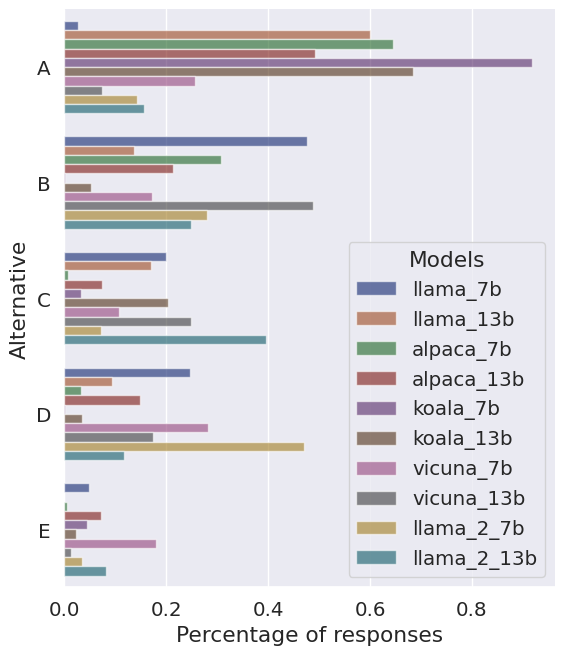

In [24]:
sns.set_theme()
sns.set(font_scale=1.3)
g = sns.catplot(data = percents, kind = "bar", y = "alternative", x = 'percent', hue = 'model',
    errorbar="sd", palette="dark", alpha=.6, height=6)
g.despine(left=True)
g.set_axis_labels("Percentage of responses","Alternative")
g.legend.set_title("")
g.fig.set_figwidth(8)
g.fig.set_figheight(7)
g._legend.remove()
plt.legend(loc='lower right',title="Models")
plt.savefig("plots/distribution-alternatives-english.svg",format="svg")